<div class="alert alert-block alert-success">
    <h1 align="center">Random Search for Hyper Parameter Tuning</h1>
    <h3 align="center"> Tabular Time Series</h3>
    <h5 align="center">Github: (https://github.com/MTisMT)</h5>
</div>

In [1]:
import pickle
import requests
import itertools
import numpy as np
import pandas as pd
import xgboost as xgb
from scipy import stats
from scipy.stats.mstats import spearmanr
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use("seaborn")
import lightgbm as lgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
 
import tensorflow as tf
from keras import optimizers
from keras import regularizers
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, Input

# Read data
A financial market dataset

In [2]:
X = pd.read_csv("X_train.csv")
y = pd.read_csv("y_train.csv")

In [3]:
X.describe()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16
count,16651.000000,16651.000000,16651.000000,16651.000000,16651.000000,16651.000000,16651.000000,16651.000000,16651.000000,16651.000000,16651.000000,16651.000000,16651.000000,16651.000000,16651.000000,16651.000000
mean,0.489805,0.255825,0.499910,0.499910,0.499910,0.499910,0.255750,0.499910,0.499910,0.499910,0.499910,0.499910,0.499910,0.499910,0.499910,0.499910
std,0.357614,0.282637,0.353787,0.353787,0.353787,0.353787,0.283202,0.353787,0.353787,0.353787,0.353787,0.353787,0.353787,0.353787,0.353787,0.353787
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.000000,0.250000,0.250000,0.250000,0.250000,0.000000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000
50%,0.500000,0.250000,0.500000,0.500000,0.500000,0.500000,0.250000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
75%,0.750000,0.500000,0.750000,0.750000,0.750000,0.750000,0.500000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000
max,1.000000,0.750000,1.000000,1.000000,1.000000,1.000000,0.750000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
y.describe()

,y
count,16651.000000
mean,0.499910
std,0.353787
min,0.000000
25%,0.250000
50%,0.500000
75%,0.750000
max,1.000000


# Time series cross validation

In [5]:
def TS_crossval_block(X,y,k = 5, test_percent = 0.2):
    wsize = int(X.shape[0]//k)
    print("Each fold size: ", wsize)
    test_part = int(test_percent * wsize)
    train_lb = 0
    train_ub = train_lb + wsize
    X_train={}; y_train={}
    X_test={}; y_test={}
    
    fig = plt.figure(figsize = (12,6))
    ax = fig.add_subplot(111)
    
    for i in range(1,k+1):
        
        train_ub = int((1-test_percent)* wsize) +train_lb
        test_part = int(test_percent * wsize)
#         train_ub = train_lb + wsize
        print("fold",i,"===> train: ",train_lb,"_",train_ub," | test: ",train_ub,"_",train_ub + test_part)
        print(f"Train Percentage: {(train_ub-train_lb) /(train_ub + test_part-train_lb):.0%}")
        print("_"*80)
        X_train[i] = X[train_lb:train_ub]; y_train[i] = y[train_lb:train_ub]
        X_test[i] = X[train_ub:train_ub +test_part]; y_test[i] = y[train_ub:train_ub + test_part]
        
        rect1 = matplotlib.patches.Rectangle(((train_lb/X.shape[0])*100,2*i*10), ((train_ub-train_lb)/X.shape[0])*100, 10, color='blue')
        rect2 = matplotlib.patches.Rectangle(((train_ub/X.shape[0])*100, 2*i*10),((test_part)/X.shape[0])*100 , 10, color='k')
        ax.add_patch(rect1)
        ax.add_patch(rect2)
        
        train_lb += wsize
        
    print("\n") 
    plt.xlim([0, 100])
    plt.ylim([0, 2*10*(k+1)])
    plt.show()
    return X_train,X_test,y_train,y_test

In [6]:
def TS_crossval(X,y,k = 5, test_percent = 0.2):
    wsize = int(X.shape[0]//k)
    test_part = int(test_percent * wsize)
    train_lb = 0
#     train_ub = train_lb + wsize
    X_train={}; y_train={}
    X_test={}; y_test={}
    
    fig = plt.figure(figsize = (12,6))
    ax = fig.add_subplot(111)
    
    for i in range(1,k+1):
        
        train_ub = int((1-test_percent)* (train_lb + wsize))
        test_part = int(test_percent *(train_lb + wsize))
        print("fold",i,"===> train: ",0,"_",train_ub," | test: ",train_ub,"_",train_ub + test_part)
        print(f"Train Percentage: {train_ub /(train_ub + test_part):.0%}")
        print("_"*80)
        X_train[i] = X[0:train_ub]; y_train[i] = y[0:train_ub]
        X_test[i] = X[train_ub:train_ub + test_part]; y_test[i] = y[train_ub:train_ub + test_part]
        train_lb += wsize
        
        rect1 = matplotlib.patches.Rectangle((0,2*i*10), (train_ub/X.shape[0])*100, 10, color='blue')
        rect2 = matplotlib.patches.Rectangle(((train_ub/X.shape[0])*100, 2*i*10),((test_part)/X.shape[0])*100 , 10, color='k')
        ax.add_patch(rect1)
        ax.add_patch(rect2)
    print("\n") 
    plt.xlim([0, 100])
    plt.ylim([0, 2*10*(k+1)])
    plt.show()
    return X_train,X_test,y_train,y_test

fold 1 ===> train:  0 _ 2664  | test:  2664 _ 3330
Train Percentage: 80%
________________________________________________________________________________
fold 2 ===> train:  0 _ 5328  | test:  5328 _ 6660
Train Percentage: 80%
________________________________________________________________________________
fold 3 ===> train:  0 _ 7992  | test:  7992 _ 9990
Train Percentage: 80%
________________________________________________________________________________
fold 4 ===> train:  0 _ 10656  | test:  10656 _ 13320
Train Percentage: 80%
________________________________________________________________________________
fold 5 ===> train:  0 _ 13320  | test:  13320 _ 16650
Train Percentage: 80%
________________________________________________________________________________




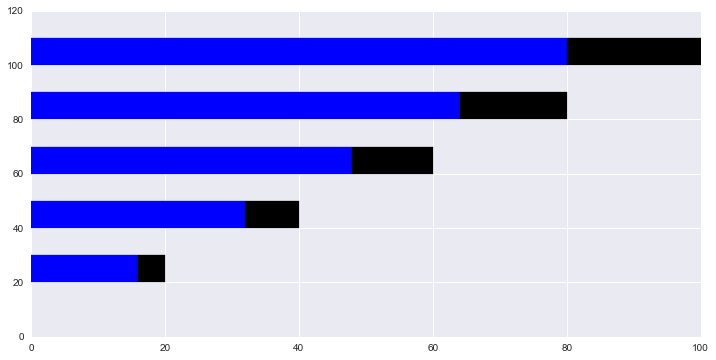

In [7]:
folds=5
X_train,X_test,y_train,y_test=TS_crossval(X, y, k=folds, test_percent = 0.2)

# or with subsamples
# sub_sample = 100
# X_train,X_test,y_train,y_test=TS_crossval(X[:sub_sample],y[:sub_sample],
#                                                 k=folds, test_percent = 0.2) #Sub

# Score of models

In [8]:
def scorer(y_test, y_pred):
    # Can be any score based on the problem
    score = (stats.spearmanr(y_test, y_pred))[0]
    return score

# Deep Learning models

## MLP

In [9]:
def ANN_model(X,y,X_t,y_t,lr=0.005,bs=64, ep=10, actv='relu',
                  min_lr=0.00005, f_lr=0.7, reg=0,h_layers=2, multitask=False, nodes = 512, drpout=0.2):
    #X=AE_r.predict(X)
    #X_t=AE_r.predict(X_t)
    score={}
    input_sz=X.shape[1]
    model = Sequential()
    model.add(Input(shape=(input_sz,)))
    #model.add(Dropout(0.1))
    model.add(Dense(nodes*2,activation=actv, kernel_regularizer=regularizers.l1_l2(l1=reg, l2=reg),
                    bias_regularizer=regularizers.l2(reg)))
    model.add(Dropout(drpout))
    for h_layer in range(int(h_layers)+1):
        model.add(Dense(nodes,activation=actv, kernel_regularizer=regularizers.l1_l2(l1=reg, l2=reg),
                        bias_regularizer=regularizers.l2(reg)))
        model.add(Dropout(drpout))
    #model.add(Dense(100,activation=actv, kernel_regularizer=regularizers.l1_l2(l1=reg, l2=reg),
     #                   bias_regularizer=regularizers.l2(reg)))
    #model.add(Dropout(0.3))
    if multitask:
        model.add(Dense(y.shape[1],activation='sigmoid'))
    else: 
        model.add(Dense(1,activation='sigmoid'))
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    #opt = tf.keras.optimizers.SGD(learning_rate=lr)
    model.compile(optimizer=opt,loss='mse')
    ES = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=20)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=f_lr,
                              patience=6,verbose=1, min_lr=min_lr)
#     print("Epoch LR: ",K.eval(model.optimizer.lr))
    model.hist = model.fit(X,y,epochs=ep, callbacks=[ES,reduce_lr],
              validation_data=(X_t,y_t),shuffle=False, batch_size=bs,verbose=1)
    if multitask:
        
        for i in range(y.shape[1]):
            score[str(i)+'_'+'train_score'] = scorer(y.iloc[:,i],model.predict(X)[:,i])
            score[str(i)+'_'+'test_score'] = scorer(y_t.iloc[:,i],model.predict(X_t)[:,i])
    else:
        for i in range(1):
            score[str(i)+'_'+'train_score'] = scorer(y,model.predict(X)[:,i])
            score[str(i)+'_'+'test_score'] = scorer(y_t,model.predict(X_t)[:,i])

    return model, score

# Conv ML model

## XGboost

In [10]:
def xg_boost_r(X_train, y_train,X_test=None ,y_test=None,n_est=300,lr=0.001,max_d=2,subcols=0.5,min_leaf=3):
    
    model = xgb.XGBRegressor(objective='reg:squarederror', max_depth=max_d, learning_rate=lr,
                          n_estimators=n_est, n_jobs=-1, colsample_bytree=subcols,min_child_weight=min_leaf)
    model.fit(X_train, y_train)

    pred_train = model.predict(X_train)
    model.train_score=scorer(y_train, pred_train)
    if X_test is not None and y_test is not None:
        pred_test = model.predict(X_test)
        model.test_score=scorer(y_test, pred_test)
    
    return model

In [11]:
def lightgbm_r(X_train, y_train,X_test=None ,y_test=None,n_est=300,lr=0.01,max_d=2,subcols=0.5,min_leaf=31):
    
    model = lgb.LGBMRegressor(max_depth=max_d, learning_rate=lr,
                          n_estimators=n_est, colsample_bytree=subcols,num_leaves=min_leaf)
    model.fit(X_train, y_train)

    pred_train = model.predict(X_train)
    model.train_score=scorer(y_train, pred_train)
    if X_test is not None and y_test is not None:
        pred_test = model.predict(X_test)
        model.test_score=scorer(y_test, pred_test)
    
    return model

# Random Search
Setting "ratio = 1" in the function will turn this to a GRID SEARCH for parameters

In [12]:
def random_search(params,ratio=0.2):
    p = list(params.values())
    t = []
    for r in itertools.product(*p): t.append([*r])
    num = int(ratio * len(t))
    random_locs = np.random.permutation(len(t))[:num]
    print(num,"sets of parameters has randomly selected among", len(t), "possible sets")
    return [t[i] for i in list(random_locs)]

In [14]:
param_ann={'lr': [1e-3,1e-4,2e-5,1e-5], 
           'ep':[100,200],
           'h_layer':[1,3,6],
           'bs':[16,64],
           'nodes':[100,400,800],
           'drp' : [0.2,0.4]}
param_cml={'subcols':[0.2,0.4,0.6,0.8], 
           'max_d':[5,8,9,10,12,15],
           'lr': [0.1,0.05,0.01,0.005,0.001],
           'min_l': [15,20],
           'n_est': [90,150,300,1500]}
random_search(param_ann,ratio=0.01)

2 sets of parameters has randomly selected among 288 possible sets


[[2e-05, 100, 3, 64, 400, 0.4], [0.001, 100, 6, 64, 800, 0.4]]

# Tune Models

In [15]:
def Tune_model(data, param, ANN= True ,random_ratio = 0.2 ,model_name='model', folds = 5):
    
    X_train = data['X_train']
    X_test = data['X_test']
    y_train = data['y_train']
    y_tset = data['y_test']
    
    if ANN:
        random_parameters_ann = random_search(param,ratio=random_ratio)
    else:
        random_parameters_cml = random_search(param,ratio=random_ratio)
    
    Grid_cv=pd.DataFrame(columns=param.keys())
    Grid_cv['test_score_mean']=np.nan
    Grid_cv['test_score_std']=np.nan
    Grid_cv['train_score_mean']=np.nan
    Grid_cv['train_score_std']=np.nan
    for k in range(1,folds+1):
        Grid_cv[f'test_score_{k}']=np.nan
    for k in range(1,folds+1):
        Grid_cv[f'train_score_{k}']=np.nan

    #####TUNE Classic ML Model ######
    if not ANN:
        print(len(random_parameters_cml),' models each in' , folds , 'time series cross validation ...')

        i=1;
        counter = 0
        for subcols,max_d,lr,min_l,n_est in random_parameters_cml:
            counter +=1
            test_score=[]
            train_score=[]
            if  counter%10 == 0:
                print('HyperParam set',counter)
            for k in range(1,folds+1):
              
                  #model= xg_boost_r(X_train[k],y_train[k],X_test[k],y_test[k],
                  #                      n_est=500,lr=lr,max_d=max_d,subcols=subcols,min_leaf=min_l)

                model = lightgbm_r(X_train[k],y_train[k],X_test[k],y_test[k],
                                        n_est=n_est,lr=lr,max_d=max_d,subcols=subcols,min_leaf=min_l)

                test_score.append(model.test_score)
                train_score.append(model.train_score)

            Grid_cv.loc[i]=[subcols, max_d, lr,min_l, n_est,np.mean(test_score),np.std(test_score),
                            np.mean(train_score),np.std(train_score),
                           *test_score,*train_score]
            i+=1
        print('Done!')
    if ANN:

        print(len(random_parameters_ann),' models each in' , folds , 'time series cross validation ...')

        i=1
        counter = 0
        for lr,ep,h_lr,bs,nodes,drp in random_parameters_ann:
            counter +=1
            test_score=[]
            train_score=[]
            for k in range(1,folds+1):
                print(counter,'HyperParam set', 'in', k,'crossval fold')

                model ,score = ANN_model(X_train[k],y_train[k],X_test[k],y_test[k],
                                      lr=lr,bs=bs, ep=ep, actv='relu',min_lr=0.00001*lr,
                                      f_lr=0.7, reg=0, h_layers=h_lr, nodes = nodes, drpout=drp)

                test_score.append(score['0_test_score'])
                train_score.append(score['0_train_score'])
                
            Grid_cv.loc[i]=[lr, ep, h_lr, bs, nodes, drp, np.mean(test_score),np.std(test_score),
                            np.mean(train_score),np.std(train_score),
                           *test_score,*train_score]
            i+=1
        print('Done!')
        
    return Grid_cv

# Let's  Tune

In [16]:
data={'X_train': X_train, 'X_test': X_test,
     'y_train': y_train, 'y_test': y_test}

In [21]:
param_ann={'lr': [1e-3,1e-4,1e-5], 
           'ep':[10,20],
           'h_layer':[1,3],
           'bs':[64],
           'nodes':[100,400],
           'drp' : [0.2,0.4]}
param_cml={'subcols':[0.2,0.4,0.6,0.8], 
           'max_d':[5,8,9,10,12,15],
           'lr': [0.1,0.05,0.01,0.005,0.001],
           'min_l': [15,20],
           'n_est': [90,150,300,1500]}

random_ratio = 0.1
random_search(param_ann,ratio=random_ratio)

4 sets of parameters has randomly selected among 48 possible sets


[[1e-05, 20, 3, 64, 100, 0.4],
 [0.0001, 10, 1, 64, 400, 0.4],
 [1e-05, 10, 3, 64, 400, 0.2],
 [0.001, 20, 1, 64, 100, 0.2]]

In [22]:
Random_cv = Tune_model(data, param = param_ann, ANN= True, random_ratio = random_ratio , model_name='ANN', folds = folds)
# Random_cv.to_csv('tune_random_search.csv',index=False)

4 sets of parameters has randomly selected among 48 possible sets
4  models each in 5 time series cross validation ...
1 HyperParam set in 1 crossval fold
Epoch 1/10
42/42 [==============================] - 0s 12ms/step - loss: 0.1276 - val_loss: 0.1306
Epoch 2/10
42/42 [==============================] - 0s 9ms/step - loss: 0.1251 - val_loss: 0.1314
Epoch 3/10
42/42 [==============================] - 0s 9ms/step - loss: 0.1242 - val_loss: 0.1316
Epoch 4/10
42/42 [==============================] - 0s 11ms/step - loss: 0.1235 - val_loss: 0.1321
Epoch 5/10
42/42 [==============================] - 0s 9ms/step - loss: 0.1234 - val_loss: 0.1315
Epoch 6/10
42/42 [==============================] - 0s 11ms/step - loss: 0.1232 - val_loss: 0.1325
Epoch 7/10
39/42 [==========================>...] - ETA: 0s - loss: 0.1230
Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
42/42 [==============================] - 0s 9ms/step - loss: 0.1222 - val_loss: 0.1325
Epoch 8/10
4

In [23]:
Random_cv

,lr,ep,h_layer,bs,nodes,drp,test_score_mean,test_score_std,train_score_mean,train_score_std,test_score_1,test_score_2,test_score_3,test_score_4,test_score_5,train_score_1,train_score_2,train_score_3,train_score_4,train_score_5
1,0.00100,10.0,1.0,64.0,400.0,0.4,0.085989,0.037364,0.157224,0.034835,0.029873,0.061162,0.092677,0.108748,0.137488,0.216755,0.173812,0.139496,0.117324,0.138734
2,0.00001,20.0,1.0,64.0,400.0,0.2,0.096481,0.041767,0.127713,0.006259,0.032846,0.068664,0.103415,0.126910,0.150567,0.138644,0.127212,0.123905,0.119945,0.128860
3,0.00010,10.0,3.0,64.0,400.0,0.2,0.097142,0.041214,0.151115,0.014985,0.038706,0.071361,0.091310,0.129412,0.154919,0.177604,0.153053,0.132526,0.142777,0.149616
4,0.00001,10.0,1.0,64.0,100.0,0.2,0.044498,0.047410,0.049690,0.023009,0.015504,0.001842,0.016246,0.057099,0.131798,0.031275,0.019121,0.061078,0.052102,0.084874
